# APPENDIX 

# Back-propagation for a non-linear classifier 

In [1]:
#Import the necessary libraries 
import numpy as np
from IPython.display import Image
import sys
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns  # Fancier plots
from math import exp
from random import random
sns.set_style('darkgrid')
np.random.seed(seed=4)
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Neural network architecture for sigmoid function
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 80, "activation": "sigmoid"},
    {"input_dim": 80, "output_dim": 1, "activation": "sigmoid"},
]

#Neural network architecture for hyperbolic function
NN_ARCHITECTURE_HYP= [
    {"input_dim": 2, "output_dim": 80, "activation": "hyperbolic"},
    {"input_dim": 80, "output_dim": 1, "activation": "hyperbolic"},
]

In [3]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [4]:
#Define the activation function (Sigmoid and hyperbolic)

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def hyperbolic(Z):
    return np.tanh(Z)

def hyperbolic_backward(dA,Z):
    a = np.tanh(Z)
    return dA *(1 - (a**2))
    

In [5]:
#Forward Propagation for one neuron

def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="sigmoid"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation == "sigmoid":
        activation_func = sigmoid
    elif activation == "hyperbolic":
        activation_func = hyperbolic
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

In [7]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

In [8]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [9]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()


In [10]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="sigmoid"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    elif activation == "hyperbolic":
        backward_activation_func = hyperbolic_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [11]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [12]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [13]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

In [14]:
GRID_X_START = -2
GRID_X_END = 2
GRID_Y_START = -2.0
GRID_Y_END = 2

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid


In [15]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(8,4))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1,colors="white")
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral)
    if(file_name):
        plt.savefig(file_name)
        plt.close()

In [16]:
def callback_numpy_plot(index, params):
    plot_title = "Model - It: {:05}".format(index)
    file_name = "model_{:05}.png".format(index//100)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

# Build Training and Testing Data

In [17]:
#Training Data (without noise)
x_inside = np.random.uniform(-1,1,100)
x_noise = np.random.uniform(-0.2,0.2,100)
x_inside = np.add(x_inside,x_noise)
y_inside = np.random.uniform(-1,1,100)
xs_red = x_inside
ys_red = y_inside

x_outside_left = np.random.uniform(-2,-1,25)
y_outside_left = np.random.uniform(-2,2,25)

x_outside_right = np.random.uniform(1,2,25)
y_outside_right = np.random.uniform(-2,2,25)

x_outside_up = np.random.uniform(-0.5,1,25)
y_outside_up = np.random.uniform(1,2,25)

x_outside_down = np.random.uniform(-0.5,1,25)
y_outside_down = np.random.uniform(-1,-2,25)

xs_1 = np.append(x_outside_left,x_outside_right)
xs_2 = np.append(x_outside_up,x_outside_down)
xs_blue= np.append(xs_1,xs_2)

x_outside_noise = np.random.uniform(-0.2,0.2,100)
xs_blue = np.add(xs_blue , x_outside_noise)

ys_1 = np.append(y_outside_left,y_outside_right)
ys_2 = np.append(y_outside_up,y_outside_down)
ys_blue= np.append(ys_1,ys_2)

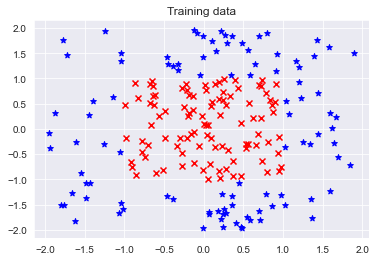

In [18]:
#Visualize Training data 
plt.figure
plt.title("Training data")
plt.scatter(xs_red,ys_red,color='red',marker='x')
plt.scatter(xs_blue,ys_blue,color='blue',marker='*')


In [19]:
x1_train = np.append(xs_blue,xs_red).reshape(200,1)
x2_train = np.append(ys_blue,ys_red).reshape(200,1)

X_train = np.array((x1_train,x2_train)).T
X_train = X_train.reshape(200,2)

#Label the data as class 1 and class 0
y_train = np.vstack((np.zeros((xs_blue.shape[0], 1)),np.ones((xs_red.shape[0], 1)))).flatten().astype(int)



In [20]:
# Test data
x_inside1 = np.random.uniform(-1,1,50)
x_noise2 = np.random.uniform(-0.2,0.2,50)
x_inside1 = np.add(x_inside1,x_noise2)
y_inside1 = np.random.uniform(-1,1,50)
xs_red1 = x_inside1
ys_red1 = y_inside1


x_outside_left1 = np.random.uniform(-2,-1,15)
y_outside_left1 = np.random.uniform(-2,2,15)

x_outside_right1 = np.random.uniform(1,2,15)
y_outside_right1 = np.random.uniform(-2,2,15)

x_outside_up1 = np.random.uniform(-0.5,1,10)
y_outside_up1 = np.random.uniform(1,2,10)

x_outside_down1 = np.random.uniform(-0.5,1,10)
y_outside_down1 = np.random.uniform(-1,-2,10)

xs_11 = np.append(x_outside_left1,x_outside_right1)
xs_21 = np.append(x_outside_up1,x_outside_down1)
xs_blue1= np.append(xs_11,xs_21)

x_outside_noise1 = np.random.uniform(-0.2,0.2,50)
xs_blue1 = np.add(xs_blue1 , x_outside_noise1)

ys_11 = np.append(y_outside_left1,y_outside_right1)
ys_21= np.append(y_outside_up1,y_outside_down1)
ys_blue1= np.append(ys_11,ys_21)


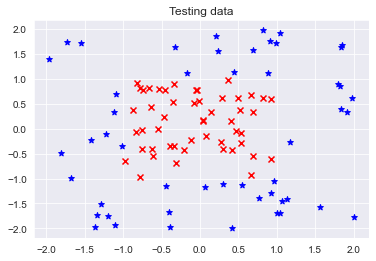

In [21]:
#Visualize Testing Data
plt.title("Testing data")
plt.scatter(xs_red1,ys_red1,color='red',marker='x')
plt.scatter(xs_blue1,ys_blue1,color='blue',marker='*')
plt.savefig("Test_data.png")

In [22]:
x1_test = np.append(xs_blue1,xs_red1).reshape(100,1)
x2_test = np.append(ys_blue1,ys_red1).reshape(100,1)
y_test = np.vstack((np.zeros((xs_blue1.shape[0], 1)), 
               np.ones((xs_red1.shape[0], 1)))).flatten().astype(int)
X_test = np.array((x1_test,x2_test)).T
X_test = X_test.reshape(100,2)


# Running the model 

## Using hyperbolic activation function

In [23]:
# Running the model for hyperbolic function
OUTPUT_DIR = "./binary_classification_vizualizations_hyp/"

params_values_hyp = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE_HYP, 80000, 0.01, False, callback_numpy_plot)


In [24]:
#Accuracy
Y_test_hat_hyp, _ = full_forward_propagation(np.transpose(X_test), params_values_hyp, NN_ARCHITECTURE_HYP)
acc_test_hyp = get_accuracy_value(Y_test_hat_hyp, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} ".format(acc_test_hyp))

Test set accuracy: 1.00 


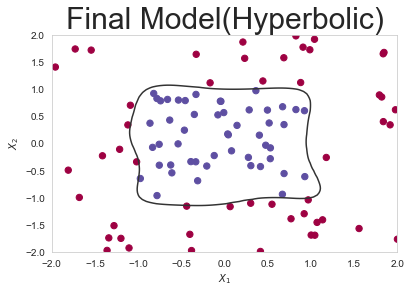

In [25]:
#Plot with decision boundary
prediction_probs_hyp, _ = full_forward_propagation(np.transpose(grid_2d), params_values_hyp, NN_ARCHITECTURE_HYP)
prediction_probs_hyp = prediction_probs_hyp.reshape(prediction_probs_hyp.shape[1], 1)
make_plot(X_test, y_test, "Final Model(Hyperbolic)", file_name=None, XX=XX, YY=YY, preds=prediction_probs_hyp)

## Using sigmoid activation function

In [26]:
# Running the model for Sigmoid function
OUTPUT_DIR = "./binary_classification_vizualizations/"
params_values_sig = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 80000, 0.01, False, callback_numpy_plot)


In [27]:
#Accuracy
Y_test_hat_sig, _ = full_forward_propagation(np.transpose(X_test), params_values_sig, NN_ARCHITECTURE)
acc_test_sig = get_accuracy_value(Y_test_hat_sig, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} ".format(acc_test_sig))

Test set accuracy: 0.84 


In [28]:
#Plot with decision boundary
prediction_probs_sig, _ = full_forward_propagation(np.transpose(grid_2d), params_values_sig, NN_ARCHITECTURE)
prediction_probs_sig = prediction_probs_hyp.reshape(prediction_probs_sig.shape[1], 1)
make_plot(X_test, y_test, "Final Model(Sigmoid)", file_name="Sigmoid.png", XX=XX, YY=YY, preds=prediction_probs_sig)

# Confusion matrix 

## For Hyperbolic function

In [29]:
y_pred1 = convert_prob_into_class(Y_test_hat_hyp)
y_pred1= y_pred1.flatten().astype(int)

In [30]:
a = y_test.reshape((y_test.shape[0], 1)).T
a =a.reshape(100,)

In [31]:
print(confusion_matrix(a,y_pred1))
print(classification_report(a,y_pred1))

[[50  0]
 [ 0 50]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



[[50  0]
 [ 0 50]]


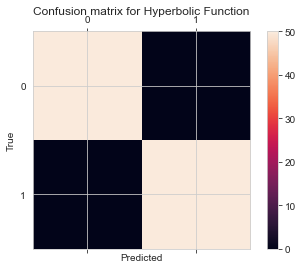

In [32]:
labels = ['0', '1']
cm = confusion_matrix(a, y_pred1)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Hyperbolic Function')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#plt.savefig("Confusion matrix for Hyperbolic Function.png")

## For sigmoid Function 

In [33]:
y_pred2 = convert_prob_into_class(Y_test_hat_sig)
y_pred2= y_pred2.flatten().astype(int)

In [34]:
print(confusion_matrix(a,y_pred2))
print(classification_report(a,y_pred2))

[[39 11]
 [ 5 45]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        50
           1       0.80      0.90      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[[39 11]
 [ 5 45]]


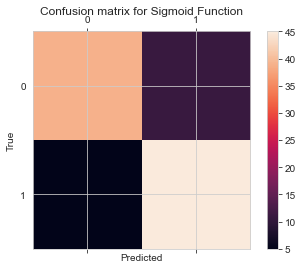

In [35]:
from sklearn.metrics import confusion_matrix

labels = ['0', '1']
cm = confusion_matrix(a, y_pred2)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Sigmoid Function')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#plt.savefig("Confusion matrix for Sigmoid Function.png")

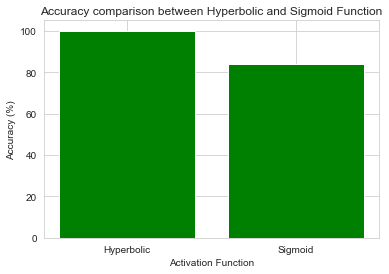

In [36]:
# Bar graph 
x = ['Hyperbolic', 'Sigmoid']
energy = [acc_test_hyp*100, acc_test_sig*100]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color='green')
plt.xlabel("Activation Function")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy comparison between Hyperbolic and Sigmoid Function")

plt.xticks(x_pos, x)
#plt.savefig("Accuracy.png")
plt.show()